# 1. Importando bibliotecas

In [78]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import glob
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem import RSLPStemmer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package punkt to /Users/andre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/andre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /Users/andre/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# 2. Lendo dados

In [79]:
path = "../data/tweet_iteracoes/"

csv_files = glob.glob(path + "/*.csv")

math_patter = r'/tweet_iteracoes/(\d+)_\d{4}-\d{2}-\d{2}'

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file).assign(post_id=re.search(math_patter, file).group(1)) for file in csv_files)

# Concatenate all DataFrames
df_tweets_iteractions   = pd.concat(df_list, ignore_index=True)
df_tweets_iteractions['post_id']=df_tweets_iteractions['post_id'].astype(int)

In [80]:
df_tweets_iteractions.shape

(647, 4)

In [81]:
df_tweets_iteractions.head()

,full_text,created_at,id,post_id
0,@LoiraNoob Maravilhosas ❤️\nQuando eu tive jun...,2023-04-09 15:56:19+00:00,1645093289551331332,1643361688639471617
1,"@BRKsEDU Vi assim q saiu, excelente vídeo edu,...",2023-04-07 19:30:27+00:00,1644422403693375506,1644096545598455812
2,@BRKsEDU Curtindo muito esses seus vídeos dos ...,2023-04-07 01:38:58+00:00,1644152755777417217,1644096545598455812
3,@BRKsEDU Edu no dia 04/04 fui vítima de um gol...,2023-04-06 22:30:07+00:00,1644105231456673795,1644096545598455812
4,"@BRKsEDU Compra pra mim,eu sou pobre e a taxa ...",2023-04-06 22:21:01+00:00,1644102941941309441,1644096545598455812


In [82]:
path = "../data/influencer_tweets/"

csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file) for file in csv_files)

# Concatenate all DataFrames
df_influencer_tweets   = pd.concat(df_list, ignore_index=True).drop_duplicates().drop_duplicates(subset=['id'])
df_influencer_tweets['post_id'] = df_influencer_tweets['id']

In [83]:
df_tweets_iteractions.dtypes

full_text     object
created_at    object
id             int64
post_id        int64
dtype: object

## Juntando os dados dos tweets dos influencer com as respostas

In [84]:
df = df_tweets_iteractions.merge(df_influencer_tweets, on=['post_id'], how='left')

In [85]:
df.shape[0]==df_tweets_iteractions.shape[0]
# verifica se o left esta ok

True

In [86]:
df.tail()

,full_text_x,created_at_x,id_x,post_id,id_y,userID,created_at_y,full_text_y,favorite_count,retweet_count
642,@cellbit @Quackity estou até agora de boca aberta,2023-04-29 00:30:05+00:00,1652107952382263297,1652107898305011714,1652107898305011714,Cellbit,2023-04-29 00:29:52+00:00,@Quackity oi,4088,236
643,@cellbit @Quackity RAFAEL,2023-04-29 00:30:05+00:00,1652107951648256003,1652107898305011714,1652107898305011714,Cellbit,2023-04-29 00:29:52+00:00,@Quackity oi,4088,236
644,@cellbit @Quackity Mitoooo,2023-04-29 00:30:04+00:00,1652107950691872770,1652107898305011714,1652107898305011714,Cellbit,2023-04-29 00:29:52+00:00,@Quackity oi,4088,236
645,@cellbit @Quackity OIIII,2023-04-29 00:30:02+00:00,1652107942391365633,1652107898305011714,1652107898305011714,Cellbit,2023-04-29 00:29:52+00:00,@Quackity oi,4088,236
646,@cellbit @Quackity oi,2023-04-29 00:30:01+00:00,1652107937547014145,1652107898305011714,1652107898305011714,Cellbit,2023-04-29 00:29:52+00:00,@Quackity oi,4088,236


In [87]:
df.columns

Index(['full_text_x', 'created_at_x', 'id_x', 'post_id', 'id_y', 'userID',
       'created_at_y', 'full_text_y', 'favorite_count', 'retweet_count'],
      dtype='object')

## veriricando as palavras mais comuns

In [88]:
# Definir a lista de stopwords em português
stop_words = set(stopwords.words('portuguese'))


# Definir o stemmer e o lemmatizer para o idioma português
stemmer = SnowballStemmer('portuguese')
lemmatizer = WordNetLemmatizer()

# Tokenizar o texto e aplicar a limpeza
def preprocess_text(text):
        # Remover URLs
    text = re.sub(r'http\S+', '', text)
    # Remover menções e hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remover caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)
    # Normalizar o text
    text = text.lower()
    text = re.sub(r'\bu\b', 'you', text)
    text = re.sub(r'\br\b', 'are', text)
    text = re.sub(r'\bthx\b|\bty\b', 'thank you', text)
    # Tokenizar o texto
    tokens = word_tokenize(text.lower(), language='portuguese')

    # Remover stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Realizar stemming
    tokens = [stemmer.stem(token) for token in tokens]

    # Realizar lematização
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Juntar os tokens em uma única string
    clean_text = ' '.join(tokens)

    return clean_text

# Aplicar a limpeza em cada texto da coluna 'full_text'
df['clean_text_resposta'] = df['full_text_x'].apply(preprocess_text)
# Aplicar a limpeza em cada texto da coluna 'full_text'
df['clean_text_entrada'] = df['full_text_y'].apply(preprocess_text)

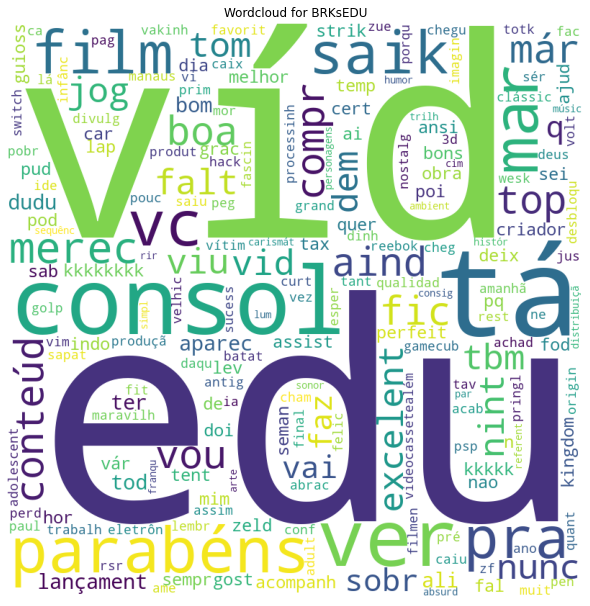

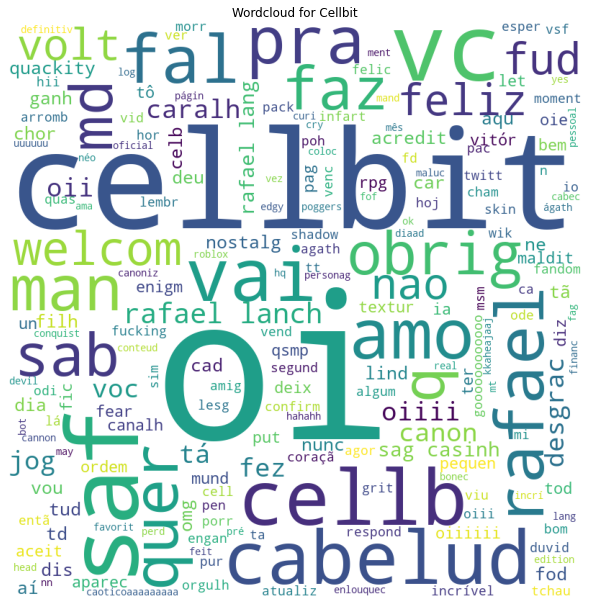

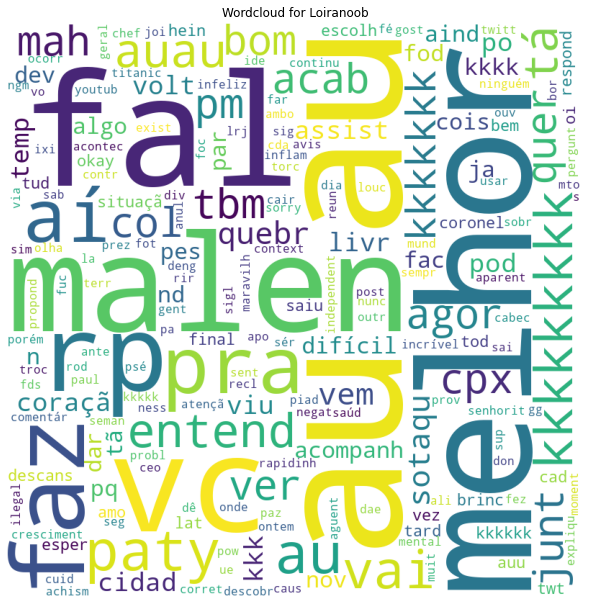

In [89]:
grouped_data = df.groupby('userID')

for group_name, group in grouped_data:
    text = ' '.join(group['clean_text_resposta'].tolist())
    preprocessed_text = preprocess_text(text)
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(preprocessed_text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Wordcloud for {group_name}")
    plt.show()

In [90]:
def get_top_words(group_text, n=10, min_length=4):
    # Tokenize the text
    tokens = word_tokenize(group_text)
    
    # Remove stopwords
    stopwords_list = stopwords.words('portuguese')
    tokens = [token for token in tokens if token not in stopwords_list]
    
    # Lemmatize the tokens
    stemmer = RSLPStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Filter out words with length less than min_length
    tokens = [token for token in tokens if len(token) >= min_length]
    
    # Count the frequency of each word
    word_freq = nltk.FreqDist(tokens)
    
    # Get the n most common words
    top_words = word_freq.most_common(n)
    
    return top_words


grouped_data = df.groupby('userID')

for group_name, group in grouped_data:
    text = ' '.join(group['clean_text_resposta'].tolist())
    preprocessed_text = preprocess_text(text)
    top_words = get_top_words(preprocessed_text, n=5)
    print(f"10 palavras mais utilizadas pelos seguidoers de {group_name}:")
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print("=====")

10 palavras mais utilizadas pelos seguidoers de BRKsEDU:
consol: 7
parabém: 7
film: 6
saik: 6
merec: 6
=====
10 palavras mais utilizadas pelos seguidoers de Cellbit:
cellbit: 47
rafael: 20
cellb: 12
cabelud: 11
obrig: 7
=====
10 palavras mais utilizadas pelos seguidoers de Loiranoob:
melhor: 9
malen: 8
paty: 6
kkkkkkkkk: 5
entend: 4
=====


In [91]:
def get_collocations(group_text, n=5, min_length=4):
    # Tokenize the text
    tokens = word_tokenize(group_text.lower())
    
    
    # Remove stopwords
    stopwords_list = stopwords.words('portuguese')
    tokens = [token for token in tokens if token not in stopwords_list]
    
    # Lemmatize the tokens
    stemmer = RSLPStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Filter out words with length less than min_length
    tokens = [token for token in tokens if len(token) >= min_length]
    
    # Get the most common bigrams and trigrams
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2)
    bigrams = finder.nbest(bigram_measures.raw_freq, n)
    
    trigram_measures = TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_words(tokens)
    finder.apply_freq_filter(2)
    trigrams = finder.nbest(trigram_measures.raw_freq, n)
    
    return bigrams, trigrams
    return top_bigrams


In [92]:
grouped_data = df.groupby('userID')

bigram_list = []
trigram_list = []
group_name_list = []

for group_name, group in grouped_data:
    print(group_name)
    group_name_list.append(group_name)
    text = ' '.join(group['clean_text_resposta'].tolist())
    preprocessed_text = preprocess_text(text)
    bigrams, trigrams = get_collocations(preprocessed_text, n=3, min_length=3)
    print(f"===== Top 5 bigrams for {group_name}:")
    for bigram in bigrams:
        print(' '.join(bigram))
    print()
    print(f"==== Top 5 trigrams for {group_name}:")
    for trigram in trigrams:
        print(' '.join(trigram))
    print("============")

    # adicionar os bigramas e trigramas às listas
    bigram_list.append([' '.join(bigram) for bigram in bigrams])
    trigram_list.append([' '.join(trigram) for trigram in trigrams])


BRKsEDU
===== Top 5 bigrams for BRKsEDU:
nunc viu
aind falt
consol nunc

==== Top 5 trigrams for BRKsEDU:
consol nunc viu
lançament vou tent
Cellbit
===== Top 5 bigrams for Cellbit:
rafael lanch
rafael lang
sag casinh

==== Top 5 trigrams for Cellbit:
sag casinh volt
welcom the qsmp
Loiranoob
===== Top 5 bigrams for Loiranoob:
amo paty
auau paty
col cpx

==== Top 5 trigrams for Loiranoob:
okay mah desc


In [93]:
pd.DataFrame({
    'group_name': group_name_list,
    'bigram': bigram_list,
    'trigram': trigram_list
}).to_csv('bigramas-dos-tweets-resposta.csv', index=False)

## Criando Clusters

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

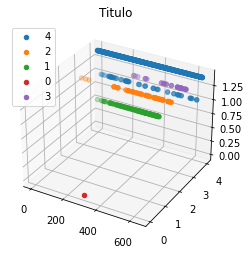

In [95]:
# Vetoriza o texto usando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text_resposta'])

# Aplica o algoritmo K-Means para clusterizar os textos
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

# Adiciona os labels dos clusters ao DataFrame
df['cluster'] = kmeans.labels_

# Visualiza os clusters em um gráfico 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label in df['cluster'].unique():
    cluster = df[df['cluster'] == label]
    ax.scatter(cluster.index, [label] * len(cluster), kmeans.transform(vectorizer.transform(cluster['clean_text_resposta']))[:,0], label=label)
ax.legend()
plt.title("Titulo")
plt.show()

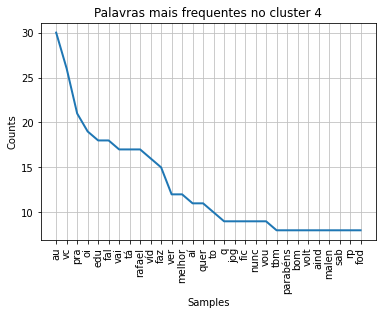

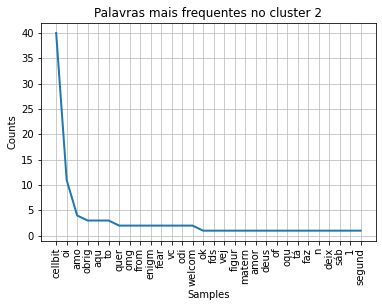

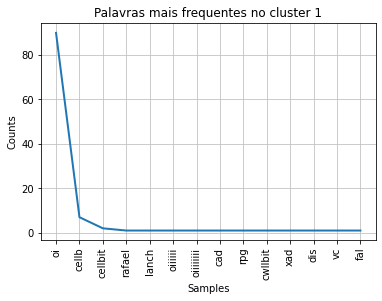

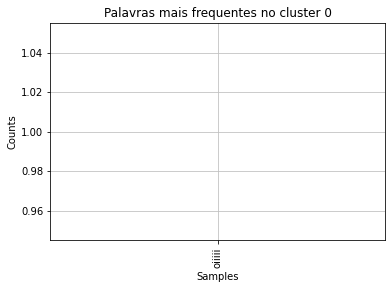

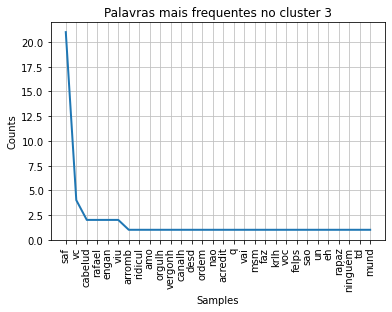

In [96]:
from nltk import FreqDist
import matplotlib.pyplot as plt

for label in df['cluster'].unique():
    cluster = df[df['cluster'] == label]
    all_words = ' '.join(cluster['clean_text_resposta']).split()
    fdist = FreqDist(all_words)
    plt.figure()
    fdist.plot(30, title=f"Palavras mais frequentes no cluster {label}")


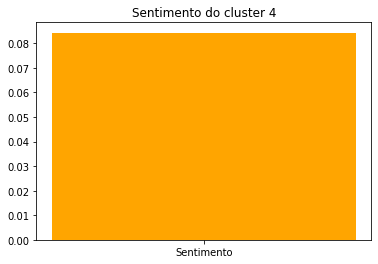

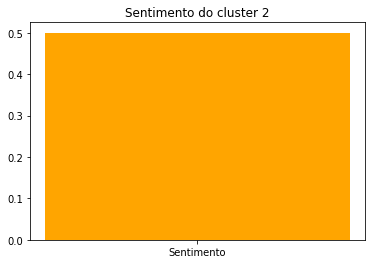

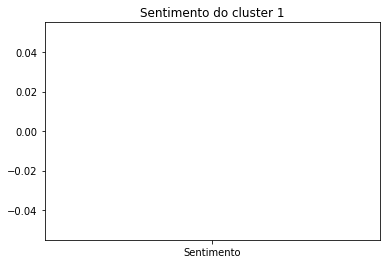

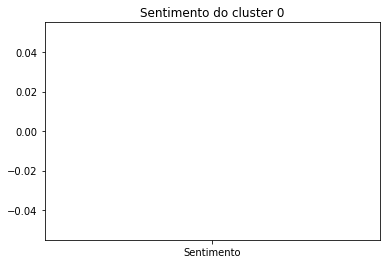

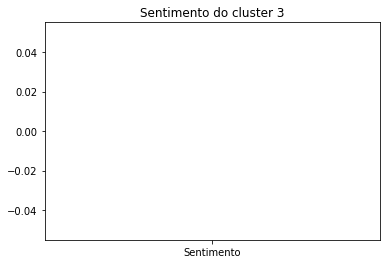

In [97]:
from textblob import TextBlob

for label in df['cluster'].unique():
    cluster = df[df['cluster'] == label]
    all_texts = ' '.join(cluster['clean_text_resposta'])
    blob = TextBlob(all_texts)
    sentiment = blob.sentiment.polarity
    plt.figure()
    plt.bar(['Sentimento'], [sentiment], color='orange')
    plt.title(f"Sentimento do cluster {label}")


## Analise de sentimentos

In [98]:
from textblob import TextBlob

def analisar_sentimento(tweet):
    blob = TextBlob(tweet)
    polaridade = blob.sentiment.polarity
    
    if polaridade > 0:
        return 'Positivo'
    elif polaridade < 0:
        return 'Negativo'
    else:
        return 'Neutro'


df['sentimento'] = df['clean_text_resposta'].apply(analisar_sentimento)


In [99]:
df.sentimento.value_counts()

Neutro      620
Positivo     18
Negativo      9
Name: sentimento, dtype: int64

In [100]:
df.groupby("userID").sentimento.value_counts()

userID     sentimento
BRKsEDU    Neutro        100
           Positivo       12
           Negativo        4
Cellbit    Neutro        430
           Negativo        3
           Positivo        3
Loiranoob  Neutro         90
           Positivo        3
           Negativo        2
Name: sentimento, dtype: int64

In [101]:
df.columns

Index(['full_text_x', 'created_at_x', 'id_x', 'post_id', 'id_y', 'userID',
       'created_at_y', 'full_text_y', 'favorite_count', 'retweet_count',
       'clean_text_resposta', 'clean_text_entrada', 'cluster', 'sentimento'],
      dtype='object')

In [ ]:
userID, sentimento, favorite_count, retweet_count

In [108]:
df.groupby('userID').agg({'favorite_count': 'max','retweet_count': 'max'})

,favorite_count,retweet_count
userID,,
BRKsEDU,3729,67
Cellbit,7076,495
Loiranoob,5717,81


In [104]:
df.groupby(['userID', 'sentimento']).size().reset_index(name='contagem')

,userID,sentimento,contagem
0,BRKsEDU,Negativo,4
1,BRKsEDU,Neutro,100
2,BRKsEDU,Positivo,12
3,Cellbit,Negativo,3
4,Cellbit,Neutro,430
5,Cellbit,Positivo,3
6,Loiranoob,Negativo,2
7,Loiranoob,Neutro,90
8,Loiranoob,Positivo,3


In [109]:
df1 =df.pivot_table(index='userID', columns='sentimento', aggfunc='size', fill_value=0)
df2 =df.groupby('userID').agg({'favorite_count': 'max','retweet_count': 'max'})
df1.merge(df2, on='userID')

,Negativo,Neutro,Positivo,favorite_count,retweet_count
userID,,,,,
BRKsEDU,4,100,12,3729,67
Cellbit,3,430,3,7076,495
Loiranoob,2,90,3,5717,81


In [111]:
df1

sentimento,Negativo,Neutro,Positivo
userID,,,
BRKsEDU,4,100,12
Cellbit,3,430,3
Loiranoob,2,90,3
